In [327]:
import matplotlib.pyplot as plt
import numpy as np
from lmfit import models
import csv

In [328]:
def calibration_factor():
    weight = 1.19/1000 # kg
    F_measured = 2460/1000 #Newton 
    F_applied = weight * 9.81
    cb_factor = F_applied / F_measured
    print(cb_factor)
calibration_factor()

0.004745487804878048


In [329]:


def Fcr(d, L, E, K=1):
    """Euler critical load for a circular rod"""
    I = np.pi * d**4 / 64
    return np.pi**2 * E * I / (K * L)**2

def Fcr_error(d, L, E, delta_d, delta_L, delta_E, K=1, delta_K=0):
    """Error propagation for Euler load"""
    I = np.pi * d**4 / 64
    F = np.pi**2 * E * I / (K * L)**2

    # klopt nog niet helemaal!
    dF_dd = np.pi**3 * E * d**3 / (16 * (K*L)**2)
    dF_dL = -2 * F / L
    dF_dE = F / E
    dF_dK = -2 * F / K

    # total error
    delta_F = np.sqrt( (dF_dd*delta_d)**2 + (dF_dL*delta_L)**2 +
                       (dF_dE*delta_E)**2 + (dF_dK*delta_K)**2 )
    return delta_F

# Example parameters
d = 0.002      # 2 mm
L = 0.03       # 3 cm
E = 4e9        # 4 GPa
K = 1
delta_d = 0.0001   # 0.1 mm uncertainty
delta_L = 0.001    # 1 mm uncertainty
delta_E = 0.5e9    # 0.5 GPa uncertainty

# Example: Square column, factor 4
factor = 4

F = factor * Fcr(d,L,E,K)
deltaF = factor * Fcr_error(d,L,E,delta_d,delta_L,delta_E,K,0)

print(f"F_max = {F:.2f} N ± {deltaF:.2f} N")


F_max = 137.81 N ± 33.77 N


[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 227
    # variables        = 2
    chi-square         = 4694389.74
    reduced chi-square = 20863.9544
    Akaike info crit   = 2259.68281
    Bayesian info crit = 2266.53271
    R-squared          = 0.12872771
[[Variables]]
    slope:      0.01264400 +/- 0.00219298 (17.34%) (init = 1)
    intercept: -0.18446364 +/- 0.05724651 (31.03%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intercept) = -0.8646


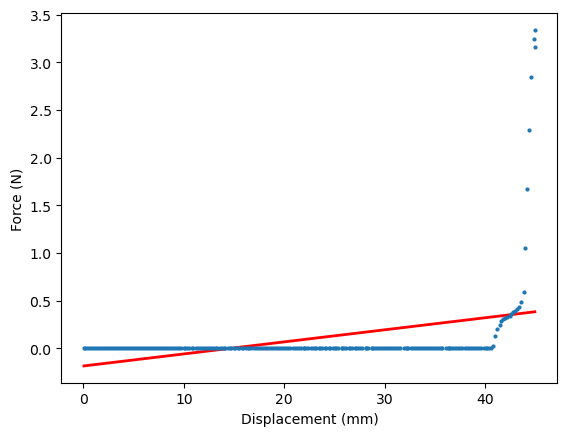

In [330]:

mod_linear = models.LinearModel()

force_list = []
displacement_list = []
time_list = []

with open("kubus_tweede_meting.csv", "r") as file:
    my_reader = csv.reader(file, delimiter=",")
    next(my_reader)   

    for row in my_reader:
        time_list.append(row[0])
        displacement_list.append(float(row[1]))
        force_list.append(float(row[2]) / -1000)


y_err = np.array(len(force_list) * [0.003])
y_inv_err = 1 / y_err

fit_result = mod_linear.fit(force_list, x=displacement_list, weights=y_inv_err)

print(fit_result.fit_report())

plt.figure()
plt.xlabel("Displacement (mm)")
plt.ylabel("Force (N)")

plt.errorbar(displacement_list, force_list, yerr=0.003, fmt='o', markersize=2)
plt.plot(displacement_list, fit_result.best_fit, 'r-', linewidth=2)

plt.show()


This is the code for the tetrahede!!

[0.0500902, 0.3050846, 0.496012, 0.6743004, 0.8621622, 1.062584, 1.2592596, 1.4551584, 1.6645, 1.8657648, 2.0700706, 2.2664278, 2.4596142, 2.6522344, 2.852409, 3.0589834, 3.2672084, 3.4581276, 3.6583524, 3.856832, 4.0549804, 4.2539412, 4.4466584, 4.6595902, 4.8480856, 5.0515484, 5.2502226, 5.4533344, 5.6496668, 5.8772202, 6.0727496, 6.2491548, 6.4501108, 6.6822038, 6.8610184, 7.0669946, 7.256031, 7.4810152, 7.6574594, 7.8704286, 8.0710104, 8.2741404, 8.4588224, 8.685852, 8.8530734, 9.061898, 9.2847692, 9.4344738, 9.6759548, 9.8558206, 10.0747996, 10.2551298, 10.461906, 10.6936416, 10.859291, 11.0920636, 11.2762518, 11.467877, 11.6825544, 11.8548258, 12.074492, 12.2690918, 12.4659376, 12.6637946, 12.8858498, 13.0632534, 13.2863476, 13.4823978, 13.6441644, 13.8490538, 14.0769174, 14.2588662, 14.4362976, 14.6514406, 14.8894886, 15.0816622, 15.266121, 15.4524084, 15.6693564, 15.8541344, 16.1022702, 16.2640012, 16.4537716, 16.6763944, 16.8629896, 17.0608274, 17.3029804, 17.5014826, 17.70526

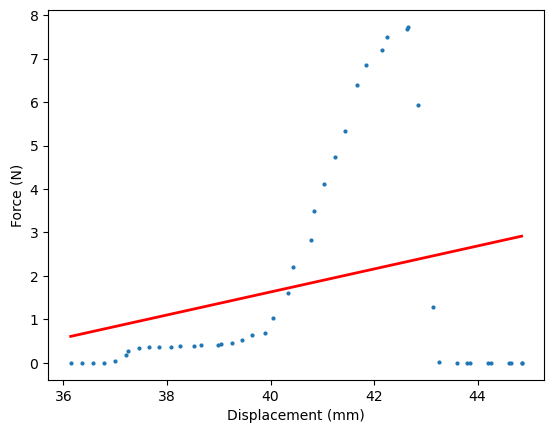

In [331]:


mod_linear = models.LinearModel()

force_list = []
displacement_list = []
time_list = []

with open("tetrahede_eerste_meting.csv", "r") as file:
    my_reader = csv.reader(file, delimiter=",")
    next(my_reader)
    for row in my_reader:
        time_list.append(row[0])
        displacement_list.append(float(row[1]))
        force_list.append(float(row[2])/-1000)

new_force = []
new_disp = []

i = 0
breek_drempel = 10    
was_prev = None
stoppen = False

while i < len(displacement_list) and stoppen == False:
    print(displacement_list)

    if displacement_list[i] > 36:
        if was_prev is None:
            was_prev = force_list[i]

        if force_list[i] < was_prev - breek_drempel:
            stoppen = True
        else:
            new_disp.append(displacement_list[i])
            new_force.append(force_list[i])
            was_prev = force_list[i]

    i += 1

y_err = np.array(len(new_force) * [0.003])
y_inv_err = 1 / y_err

fit_result = mod_linear.fit(new_force, x=new_disp, weights=y_inv_err)

print(fit_result.fit_report())

plt.figure()
plt.xlabel("Displacement (mm)")
plt.ylabel("Force (N)")
plt.errorbar(new_disp, new_force, yerr=0.003, fmt='o', markersize=2)
plt.plot(new_disp, fit_result.best_fit, 'r-', linewidth=2)
plt.show()


Now for the Pyramid!

[0.0157949, 0.0355476, 0.138638, 0.2366421, 0.335972, 0.4349791, 0.532923, 0.6326778, 0.7320188, 0.835089, 0.9402197, 1.041944, 1.1406009, 1.2362167, 1.3461306, 1.4379699, 1.5383531, 1.6348575, 1.7379345, 1.8458167, 1.9490749, 2.0443393, 2.1430427, 2.238267, 2.3412379, 2.4341123, 2.5361698, 2.6495728, 2.7481781, 2.8406459, 2.9406979, 3.0463176, 3.1348586, 3.2414444, 3.3394706, 3.4504026, 3.5483038, 3.6400613, 3.7435325, 3.8505849, 3.943054, 4.0397072, 4.1367896, 4.2482106, 4.3481462, 4.4492731, 4.5410287, 4.6429244, 4.7328412, 4.8493926, 4.9416275, 5.0479121, 5.1442053, 5.2504813, 5.333473, 5.4435982, 5.5526273, 5.6384773, 5.7372913, 5.8496551, 5.9500334, 6.0547907, 6.141908, 6.229483, 6.3479765, 6.4524238, 6.5274473, 6.6498814, 6.739671, 6.8612232, 6.9387089, 7.0484742, 7.1413162, 7.2347569, 7.3280038, 7.4399253, 7.5338888, 7.6391085, 7.7330615, 7.9009079, 7.9299088, 8.0868013, 8.1893884, 8.2919755, 8.3250077, 8.479121, 8.6061266, 8.632865, 8.7906659, 8.89618, 8.9284595, 9.0828575, 9.

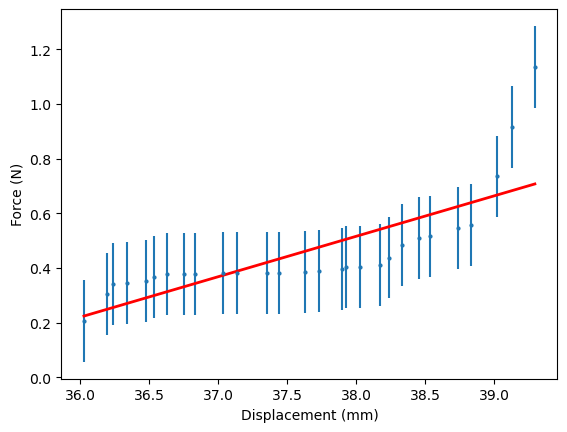

In [332]:


mod_linear = models.LinearModel()

force_list = []
displacement_list = []
time_list = []

with open("kubus_eerste_meting.csv", "r") as file:
    my_reader = csv.reader(file, delimiter=",")
    next(my_reader)
    for row in my_reader:
        time_list.append(row[0])
        displacement_list.append(float(row[1]))
        force_list.append(float(row[2])/-1000)

new_force = []
new_disp = []

breek_drempel = 0.6
was_prev = None

for disp, force in zip(displacement_list, force_list):
    print(displacement_list)
    if disp > 36:
        if was_prev is None:
            was_prev = force
        
        if force < was_prev - breek_drempel:
            break  
        else:
            new_disp.append(disp)
            new_force.append(force)
            was_prev = force

y_err = np.array([0.15] * len(new_force))  # fout per punt
y_inv_err = 1 / y_err                       # gewicht voor lmfit
fit_result = mod_linear.fit(new_force, x=new_disp, weights=y_inv_err)

print(fit_result.fit_report())

plt.figure()
plt.xlabel("Displacement (mm)")
plt.ylabel("Force (N)")
plt.errorbar(new_disp, new_force, yerr=y_err, fmt='o', markersize=2)
plt.plot(new_disp, fit_result.best_fit, 'r-', linewidth=2)
plt.show()


[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 76
    # variables        = 2
    chi-square         = 1.5747e+08
    reduced chi-square = 2127927.95
    Akaike info crit   = 1109.34332
    Bayesian info crit = 1114.00478
    R-squared          = 0.48914423
[[Variables]]
    slope:      0.32057274 +/- 0.03808390 (11.88%) (init = 1)
    intercept: -4.65349727 +/- 0.69216925 (14.87%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intercept) = -0.9703


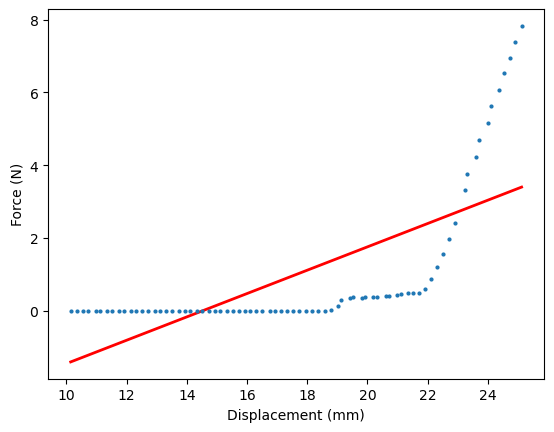

In [333]:


mod_linear = models.LinearModel()

force_list = []
displacement_list = []
time_list = []

with open("pyramide_meting_1.csv", "r") as file:
    my_reader = csv.reader(file, delimiter=",")
    next(my_reader)
    for row in my_reader:
        time_list.append(row[0])
        displacement_list.append(float(row[1]))
        force_list.append(float(row[2])/-1000)

new_force = []
new_disp = []

breek_drempel = 10
was_prev = None

for disp, force in zip(displacement_list, force_list):

    if disp > 10:
        if was_prev is None:
            was_prev = force
        
        if force < was_prev - breek_drempel:
            break  
        else:
            new_disp.append(disp)
            new_force.append(force)
            was_prev = force
    

y_err = np.array([0.001] * len(new_force))  # fout per punt
y_inv_err = 1 / y_err                       # gewicht voor lmfit
fit_result = mod_linear.fit(new_force, x=new_disp, weights=y_inv_err)

print(fit_result.fit_report())

plt.figure()
plt.xlabel("Displacement (mm)")
plt.ylabel("Force (N)")
plt.errorbar(new_disp, new_force, yerr=y_err, fmt='o', markersize=2)
plt.plot(new_disp, fit_result.best_fit, 'r-', linewidth=2)
plt.show()
